# Analysis Project: Windows or Mac?

## Intro, Imports & Data

In [1]:
# Imports
import numpy as np
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.linear_model
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading Dataset
file = './dataset/survey_data.xlsx'
survey = pd.read_excel(io=file)

# Pandas print options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Edits 
survey.rename({'What is your nationality? ': 'Nationality?'}, axis=1, inplace=True)
survey.rename({'What laptop do you currently have?': 'Current_Laptop'}, axis=1, inplace=True)
survey.rename({'What laptop would you buy in next assuming if all laptops cost the same?': 'Wished_Laptop'}, axis=1, inplace=True)
survey.rename({'What is your age?': 'Age?'}, axis=1, inplace=True)
survey.rename({'What is your ethnicity?': 'Ethnicity?'}, axis=1, inplace=True)
survey.rename({'What program are you in?': 'Program?'}, axis=1, inplace=True)
survey.rename({"Don't  generate ideas that are new and different": "Don't generate ideas that are new and different"}, axis=1, inplace=True)

### Data Cleanse & Features

#### Missing Values

This dataset has no missing values. 

In [2]:
# Code for Checking Missing Values: 
# 
# print(survey.isnull().any().any())

#### Deleting Inconsistent Observations

The following code deletes rows if responses to control questions are over 1 point away from their original responses. 

In [3]:
# Creating 3 new columns to flag absolute differences over 1

survey['RespondX'] = abs(
    survey["Respond effectively to multiple priorities.1"] -
    survey["Respond effectively to multiple priorities"])
survey['TakeX'] = abs(
    survey[
        "Take initiative even when circumstances, objectives, or rules aren't clear.1"]
    - survey[
        "Take initiative even when circumstances, objectives, or rules aren't clear"]
)
survey['EncourageX'] = abs(survey["Encourage direct and open discussions.1"] -
                           survey["Encourage direct and open discussions"])

# Deleting observations based on condition

index_ResX = survey[survey['RespondX'] > 1].index
survey.drop(index_ResX, inplace=True)

index_TakeX = survey[survey['TakeX'] > 1].index
survey.drop(index_TakeX, inplace=True)

index_EncX = survey[survey['EncourageX'] > 1].index
survey.drop(index_EncX, inplace=True)

# Deleting dummy columns once done

survey = survey.drop('RespondX', axis=1)
survey = survey.drop('TakeX', axis=1)
survey = survey.drop('EncourageX', axis=1)

# Deleting duplicate columns marked as .1

survey = survey.drop("Respond effectively to multiple priorities.1", axis=1)
survey = survey.drop("Take initiative even when circumstances, objectives, or rules aren't clear.1", axis=1)
survey = survey.drop("Encourage direct and open discussions.1", axis=1)

We deleted 7-8 observations as a result. We suspected these were untrustworthy.

#### Dummy Variables

In [4]:
# Setting Dummies for Laptop Choices
survey['Current_Dummy'] = 0
survey['Wished_Dummy'] = 0

for index, value in survey.iterrows():

    if survey.loc[index, 'Current_Laptop'] == 'Windows laptop':
        survey.loc[index, 'Current_Dummy'] = 1
        
    if survey.loc[index, 'Wished_Laptop'] == 'Windows laptop':
        survey.loc[index, 'Wished_Dummy'] = 1

    if survey.loc[index, 'Wished_Laptop'] == 'Chromebook':
        survey.loc[index, 'Wished_Dummy'] = 2
        
dummies = ['Current_Dummy','Wished_Dummy']

### Variable Groupings

#### Negative Variable Scales

From the web: 

<blockquote>
"Here is how to score IPIP scales:<br><br>
For + keyed items, the response "Very Inaccurate" is assigned a value of 1, "Moderately Inaccurate" a value of 2, "Neither Inaccurate nor Accurate" a 3, "Moderately Accurate" a 4, and "Very Accurate" a value of 5.<br><br>
For - keyed items, the response "Very Inaccurate" is assigned a value of 5, "Moderately Inaccurate" a value of 4, "Neither Inaccurate nor Accurate" a 3, "Moderately Accurate" a 2, and "Very Accurate" a value of 1."
</blockquote>
<br>
<b>We will assume that the scales are in order, and already reversed.</b>

In [5]:
# Grouping Variables
demographics = survey.loc[:,'Program?':'Ethnicity?']

psychographics = survey.loc[:,'Am the life of the party':'Drive for results']

current_laptop = survey.loc[:,'Current_Laptop']

wished_laptop = survey.loc[:,'Wished_Laptop']

#### Grouping Responses by Personality Trait

In [6]:
# EXTRAVERSION

extrav = [
    "Am the life of the party", "Don't talk a lot",
    "Feel comfortable around people", "Keep in the background",
    "Start conversations", "Have little to say",
    "Talk to a lot of different people at parties",
    "Don't like to draw attention to myself",
    "Don't mind being the center of attention", "Am quiet around strangers"
]

# AGREEABLENESS

agree = [
    "Feel little concern for others", "Am interested in people",
    "Insult people", "Sympathize with others' feelings",
    "Am not interested in other people's problems", "Have a soft heart",
    "Am not really interested in others", "Take time out for others",
    "Feel others' emotions", "Make people feel at ease"
]

# CONSCIENTIOUSNESS

conscient = [
    "Am always prepared", "Leave my belongings around",
    "Pay attention to details", "Make a mess of things",
    "Get chores done right away",
    "Often forget to put things back in their proper place", "Like order",
    "Shirk my duties", "Follow a schedule", "Am exacting in my work"
]

# EMOTIONAL STABILITY
emotion = [
    "Get stressed out easily", "Am relaxed most of the time",
    "Worry about things", "Seldom feel blue", "Am easily disturbed",
    "Get upset easily", "Change my mood a lot", "Have frequent mood swings",
    "Get irritated easily", "Often feel blue"
]

# INTELLECT

intellect = [
    "Have a rich vocabulary", "Have difficulty understanding abstract ideas",
    "Have a vivid imagination", "Am not interested in abstract ideas",
    "Have excellent ideas", "Do not have a good imagination",
    "Am quick to understand things", "Use difficult words",
    "Spend time reflecting on things", "Am full of ideas"
]

#### Hult DNA Grouping

In [7]:
# Grouping Variables
thinking = [
    'Display a growth mindset', 'Respond effectively to multiple priorities',
    "Take initiative even when circumstances, objectives, or rules aren't clear",
    'Drive for results',
    "Translate ideas into plans that are organized and realistic"
]
communication = [
    'Listen carefully to others', "Don't persuasively sell a vision or idea",
    'Effectively negotiate interests, resources, and roles',
    'Seek and use feedback from teammates',
    'Encourage direct and open discussions'
]

teamplay = [
    'Build cooperative relationships',
    'Work well with people from diverse cultural backgrounds',
    "Can't rally people on the team around a common goal",
    'Resolve conflicts constructively',
    'Coach teammates for performance and growth'
]

#### Consolidated Variables 

In [8]:
# Create 5 new 'Big 5' variables

# 1
survey['Extrovert']=survey.loc[:,extrav].sum(axis=1)  
# 2
survey['Agreeable']=survey.loc[:,agree].sum(axis=1)
# 3
survey['Conscient']=survey.loc[:,conscient].sum(axis=1)
# 4
survey['Emotional']=survey.loc[:,emotion].sum(axis=1)
# 5
survey['Intelligent']=survey.loc[:,intellect].sum(axis=1)

In [9]:
# Create 3 new 'HULT DNA' variables

# 1
survey['Thinker']=survey.loc[:,thinking].sum(axis=1) 
# 2
survey['Communicator']=survey.loc[:,communication].sum(axis=1) 
# 3
survey['Team_Player']=survey.loc[:,teamplay].sum(axis=1) 

#### Custom Variables

##### TOTAL BIG FIVE SCORE

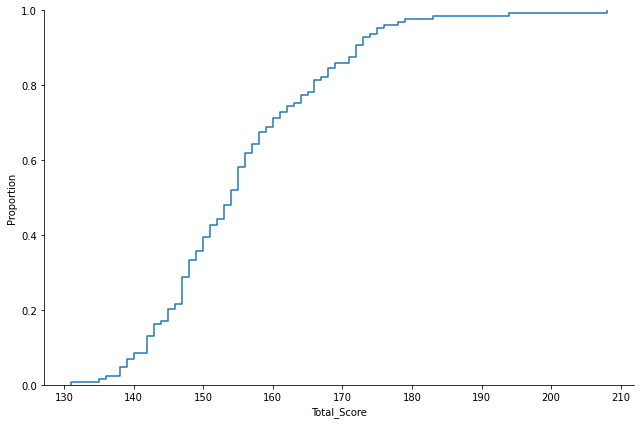

count    129.0
mean     155.5
std       12.4
min      131.0
25%      147.0
50%      154.0
75%      163.0
max      208.0
Name: Total_Score, dtype: float64


In [10]:
# The higher Big 5 score, the better. What is 'average'?
survey['Total_Score'] = survey['Extrovert'] + survey['Agreeable'] + survey[
    'Conscient'] + survey['Emotional'] + survey['Intelligent']

# Plotting Cumulative Distribution
sns.displot(data=survey, x='Total_Score', height=6, aspect=1.5, kind='ecdf')
plt.show()
print(survey['Total_Score'].describe().round(1))

We see that: 
- The average score is 155. 
- Data is skewed towards 'above-average'. HULT students are therefore very well-rounded people (or delusional).  

##### GALACTIC GENIUS / OVERBLOWN EGOS

External research suggest that tech-savvy, above-average people prefer Windows by wide margins.<br>
We should code in a dummy variable to control for this.<br>
We take the average as a reference point, since this is the _HULT average_. 

In [11]:
# Galactic Genius Var
survey['Galactic_Genius'] = 0

for index, value in survey.iterrows():

    if survey.loc[index, 'Total_Score'] > 155:
        survey.loc[index, 'Galactic_Genius'] = 1

##### EXCEPTIONAL HULT DNA HOLDERS

A variable for students who are _extremely HULT_. The group average is ~57.5.

In [12]:
# Hult DNA Var
survey['Hult_Score'] = survey['Thinker'] + survey['Communicator'] + survey['Team_Player']

survey['Hultian'] = 0

for index, value in survey.iterrows():

    if survey.loc[index, 'Hult_Score'] > np.mean(survey['Hult_Score']):
        survey.loc[index, 'Hultian'] = 1

### Slicing Dataset

#### Dataset A

In [13]:
# Copying and Dropping 
df_copy = survey.copy() 
minimal_df = df_copy.drop(psychographics, axis=1)
minimal_df = minimal_df.drop(demographics, axis=1)
minimal_df = minimal_df.drop('Wished_Laptop', axis=1)
minimal_df = minimal_df.drop('Current_Laptop', axis=1)
minimal_df = minimal_df.drop(dummies, axis=1)
minimal_df = minimal_df.drop('surveyID', axis=1)

## Scaling for PCA

Scaling so as to set variance = 1.0 for our minial dataset.

In [14]:
# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()

# FITTING the scaler with the data
scaler.fit(minimal_df)

# TRANSFORMING our data after fit
X_scaled = scaler.transform(minimal_df)

# converting scaled data into a DataFrame
minimal_scaled = pd.DataFrame(X_scaled)

# reattaching column names
minimal_scaled.columns = minimal_df.columns

## User-Defined Functions

UDFs which we will need later on. 

In [15]:
# inertia
########################################
def interia_plot(data, max_clust=50):
    """
PARAMETERS
----------
data      : DataFrame, data from which to build clusters. Dataset should be scaled
max_clust : int, maximum of range for how many clusters to check interia, default 50
    """

    ks = range(1, max_clust)
    inertias = []

    for k in ks:
        # INSTANTIATING a kmeans object
        model = KMeans(n_clusters=k)

        # FITTING to the data
        model.fit(data)

        # append each inertia to the list of inertias
        inertias.append(model.inertia_)

    # plotting ks vs inertias
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.plot(ks, inertias, '-o')

    # labeling and displaying the plot
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()


########################################
# scree_plot
########################################
def scree_plot(pca_object, export=False):
    # building a scree plot

    # setting plot size
    fig, ax = plt.subplots(figsize=(10, 8))
    features = range(pca_object.n_components_)

    # developing a scree plot
    plt.plot(features,
             pca_object.explained_variance_ratio_,
             linewidth=2,
             marker='o',
             markersize=10,
             markeredgecolor='black',
             markerfacecolor='grey')

    # setting more plot options
    plt.title('Scree Plot')
    plt.xlabel('PCA feature')
    plt.ylabel('Explained Variance')
    plt.xticks(features)

    if export == True:

        # exporting the plot
        plt.savefig(
            './analysis_images/top_customers_correlation_scree_plot.png')

    # displaying the plot
    plt.show()

## PCA Modeling

<b>IMPORTANT NOTICE:</b> 
<blockquote> 
    If you get an error stating that 'SVD did not converge', please simply RE-RUN the affected cell(s). Then, run the cells which follow the affected cell(s) manually.</blockquote>.

### Base Model

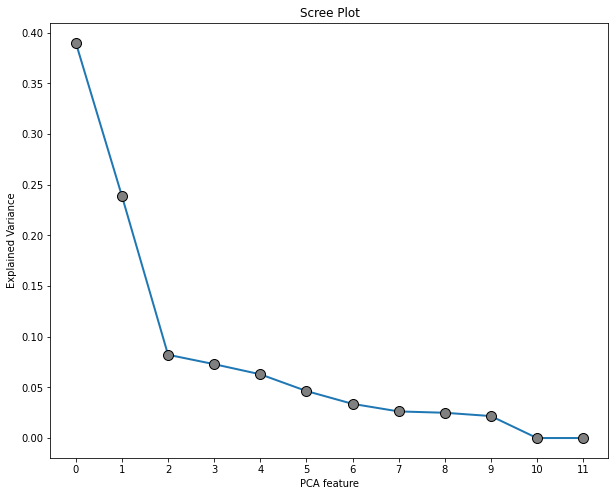

In [17]:
# INSTANTIATING a PCA object with no limit to principal components
pca = PCA(n_components = None,
          random_state = 219)

# FITTING and TRANSFORMING
survey_pca = pca.fit_transform(minimal_scaled)

# calling the scree_plot function
scree_plot(pca_object = pca)

### Reducing Components 

Reducing to 5 components so as to catch ~80% of observed variance.

In [18]:
# INSTANTIATING a new model using the first 5 principal components
pca_5 = PCA(n_components = 5,
            random_state = 219)

# FITTING and TRANSFORMING
survey_pca_5 = pca_5.fit_transform(minimal_scaled)

### Factor Loadings

In [19]:
# transposing pca components (pc = MAX)
factor_loadings = pd.DataFrame(pd.np.transpose(pca.components_))

# naming rows as original features
factor_loadings = factor_loadings.set_index(minimal_scaled.columns)

##################
# transposing pca components (pc = 5)
factor_loadings_5 = pd.DataFrame(pd.np.transpose(pca_5.components_))

# naming rows as original features
factor_loadings_5 = factor_loadings_5.set_index(minimal_scaled.columns)

# # checking the results
# print(f"""
# MAX Components Factor Loadings
# ------------------------------
# {factor_loadings.round(2)}


# 5 Components Factor Loadings
# ------------------------------
# {factor_loadings_5.round(2)}
# """)

In [20]:
# naming each principal component
factor_loadings_5.columns = ['Persona_1', 'Persona_2', 'Persona_3','Persona_4','Persona_5']

# checking the result
factor_loadings_5.round(3)

,Persona_1,Persona_2,Persona_3,Persona_4,Persona_5
Extrovert,-0.246,0.248,-0.469,-0.042,0.029
Agreeable,-0.258,0.170,-0.331,-0.293,-0.596
Conscient,-0.226,0.224,-0.372,0.264,0.617
Emotional,-0.097,0.388,0.540,0.421,-0.217
Intelligent,-0.214,0.167,0.325,-0.763,0.217
Thinker,-0.318,-0.266,0.233,-0.109,0.298
Communicator,-0.323,-0.267,-0.053,0.134,-0.270
Team_Player,-0.356,-0.236,-0.083,0.145,-0.084
Total_Score,-0.315,0.423,0.015,-0.009,-0.008
Galactic_Genius,-0.269,0.375,0.200,0.140,0.000


In [42]:
# analyzing factor strengths per customer
X_pca_reduced = pca_5.transform(minimal_scaled)

# converting to a DataFrame
X_pca_df = pd.DataFrame(X_pca_reduced)

# renaming columns
X_pca_df.columns = factor_loadings_5.columns

# checking the results
# X_pca_df

## Clustering Analysis

In [22]:
# checking variance amongst clusters
np.var(X_pca_df)

Persona_1    4.681803
Persona_2    2.865870
Persona_3    0.986346
Persona_4    0.874793
Persona_5    0.754883
dtype: float64

In [23]:
# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()

# FITTING the scaler with the data
scaler.fit(X_pca_df)

# TRANSFORMING our data after fit
X_scaled_pca = scaler.transform(X_pca_df)

# converting scaled data into a DataFrame
pca_scaled = pd.DataFrame(X_scaled_pca)

# reattaching column names
pca_scaled.columns = ['Persona_1', 'Persona_2', 'Persona_3','Persona_4','Persona_5']

# checking pre- and post-scaling variance
print(pd.np.var(X_pca_df), '\n\n')
print(pd.np.var(pca_scaled))

Persona_1    4.681803
Persona_2    2.865870
Persona_3    0.986346
Persona_4    0.874793
Persona_5    0.754883
dtype: float64 


Persona_1    1.0
Persona_2    1.0
Persona_3    1.0
Persona_4    1.0
Persona_5    1.0
dtype: float64


### Dendrogram

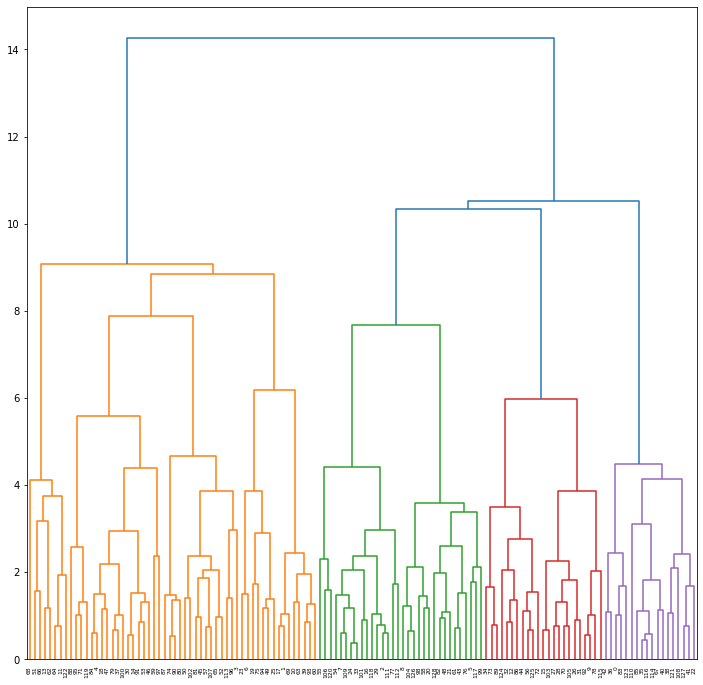

In [24]:
# grouping data based on Ward distance
standard_mergings_ward = linkage(y = pca_scaled,
                                 method = 'ward',
                                 optimal_ordering = True)

# setting plot size
fig, ax = plt.subplots(figsize=(12, 12))

# developing a dendrogram
dendrogram(Z = standard_mergings_ward,
           leaf_rotation = 90,
           leaf_font_size = 6)

# displaying the plot
plt.show()

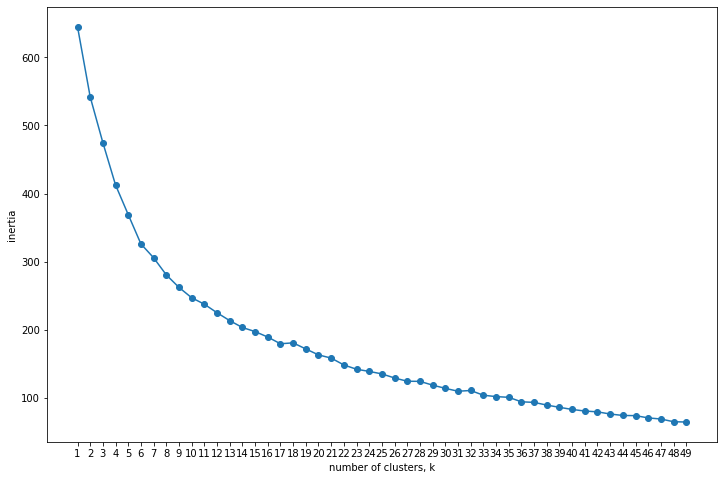

In [25]:
# calling the inertia_plot() function
interia_plot(data = pca_scaled)

### K-Means Cluster

In [26]:
# INSTANTIATING a k-Means object with clusters
minimal_k_pca = KMeans(n_clusters=5, random_state=219)

# fitting the object to the data
minimal_k_pca.fit(pca_scaled)

# converting the clusters to a DataFrame
minimal_kmeans_pca = pd.DataFrame({'Cluster': minimal_k_pca.labels_})

# checking the results
print(minimal_kmeans_pca.iloc[:, 0].value_counts())

0    28
4    28
1    27
2    25
3    21
Name: Cluster, dtype: int64


In [27]:
# storing cluster centers
centroids_pca = minimal_k_pca.cluster_centers_

# converting cluster centers into a DataFrame
centroids_pca_df = pd.DataFrame(centroids_pca)

# renaming principal components
centroids_pca_df.columns = ['Persona_1', 'Persona_2', 'Persona_3','Persona_4','Persona_5']

# checking results (clusters = rows, pc = columns)
centroids_pca_df.round(2)

,Persona_1,Persona_2,Persona_3,Persona_4,Persona_5
0,1.03,0.13,-0.87,-0.23,-0.24
1,0.11,-0.21,1.04,-0.76,0.61
2,0.16,0.36,0.65,1.12,0.02
3,-0.89,1.19,-0.69,-0.01,0.43
4,-0.60,-1.14,-0.20,-0.03,-0.70


In [28]:
# concatenating cluster memberships with principal components
clst_pca_df = pd.concat([minimal_kmeans_pca, X_pca_df], axis=1)

# checking results
clst_pca_df

# concatenating demographic information with pca-clusters
final_pca_clust_df = pd.concat([
    survey.
    loc[:, ['Program?', 'Age?', 'Gender', 'Current_Laptop', 'Wished_Laptop']],
    clst_pca_df
],
                               axis=1)

# renaming columns
final_pca_clust_df.columns = [
    'Program', 'Age', 'Gender', 'Current_Laptop', 'Wished_Laptop', 'Cluster',
    'Persona_1', 'Persona_2', 'Persona_3', 'Persona_4', 'Persona_5'
]

# checking the results
print(final_pca_clust_df.head(n=5))

                            Program   Age  Gender  Current_Laptop  \
0     DD (MIB & Business Analytics)  25.0  Female         Macbook   
1       One year Business Analytics  27.0    Male  Windows laptop   
2       One year Business Analytics  25.0    Male  Windows laptop   
3       One year Business Analytics  26.0  Female  Windows laptop   
4  DD (MBA & Disruptive innovation)  27.0    Male         Macbook   

    Wished_Laptop  Cluster  Persona_1  Persona_2  Persona_3  Persona_4  \
0         Macbook      1.0   0.901083  -0.211722  -0.093727   0.016696   
1  Windows laptop      2.0  -1.624160   0.596972   0.748899   0.945988   
2  Windows laptop      0.0   3.135402   0.689824  -0.726891  -0.213150   
3  Windows laptop      4.0  -4.769360   0.059125   0.485486  -0.649648   
4  Windows laptop      3.0   0.457567   3.536324  -0.203215  -0.088741   

   Persona_5  
0   0.945104  
1  -0.068487  
2   0.307827  
3  -1.936101  
4  -0.252806  


In [30]:
# adding a productivity step
data_df = final_pca_clust_df

# Deleting NaNs
data_df = data_df.dropna()

# checking results
data_df.head(5)

,Program,Age,Gender,Current_Laptop,Wished_Laptop,Cluster,Persona_1,Persona_2,Persona_3,Persona_4,Persona_5
0,DD (MIB & Business Analytics),25.0,Female,Macbook,Macbook,1.0,0.901083,-0.211722,-0.093727,0.016696,0.945104
1,One year Business Analytics,27.0,Male,Windows laptop,Windows laptop,2.0,-1.624160,0.596972,0.748899,0.945988,-0.068487
2,One year Business Analytics,25.0,Male,Windows laptop,Windows laptop,0.0,3.135402,0.689824,-0.726891,-0.213150,0.307827
3,One year Business Analytics,26.0,Female,Windows laptop,Windows laptop,4.0,-4.769360,0.059125,0.485486,-0.649648,-1.936101
4,DD (MBA & Disruptive innovation),27.0,Male,Macbook,Windows laptop,3.0,0.457567,3.536324,-0.203215,-0.088741,-0.252806


### Visual Analysis of Demographics 

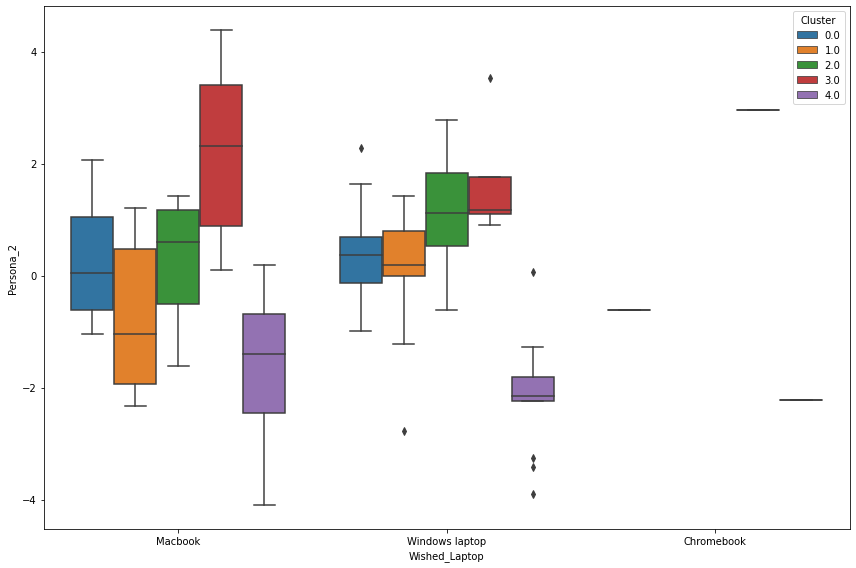

In [44]:
#
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(x    = 'Wished_Laptop',
            y    = 'Persona_2',
            hue  = 'Cluster',
            data = data_df)


# formatting and displaying the plot
plt.show()

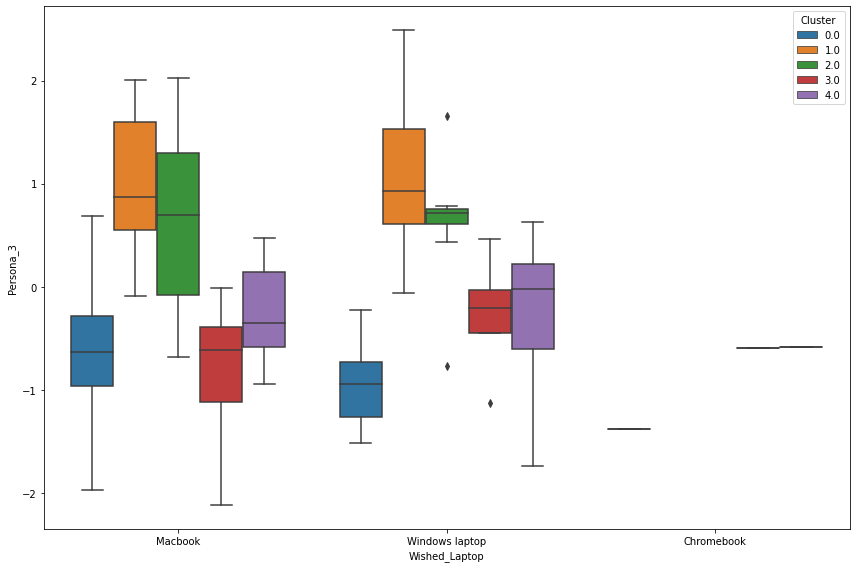

In [45]:
#
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(x    = 'Wished_Laptop',
            y    = 'Persona_3',
            hue  = 'Cluster',
            data = data_df)


# formatting and displaying the plot
plt.show()

## Report Insights

<B>UNDERSTANDING OUR PERSONAS:</B>

The answers to the survey are, of course, self-reported and therefore should be taken with a grain of salt.
<br>
How can we make sense of our principal component groupings?
<br>
<br>
<b>Persona 1:</b> 
<blockquote>
In the nicest terms possible, losers can be found in this bracket. Their scores are borderline self-depreciating, with negative values across all 5 traits. Their HULT DNA is non-existent. 
</blockquote>
<b>Persona 2:</b> 
<blockquote>
Excellent big 5 scorers. They sit on the nicer side of average, with 'Galactic Genius' as a seemingly common denominator. Possibly suffers from an overblown ego due to excessively good scores, but terrible Hult DNA.  
</blockquote>
<b>Persona 3:</b>
<blockquote>
The most HULT-compatible bracket. Very good emotional _AND_ intelligence scores in the big 5 category. However, may suffer from excessive introversion due to lowest score on extroversion. 
</blockquote>
<b>Persona 4:</b> 
<blockquote>
This type has solid emotional intelligence, but scores themselves as relatively unintelligent. They have the second best HULT DNA scores, and score well on conscientiousness. Perhaps a bracket of happy people to hang around. 
</blockquote>
<b>Persona 5:</b> 
<blockquote>
The most average person you can imagine. Placid across the board, scores almost 0 on both the HULT and Big 5 total scores. Of note are their terrible Agreeableness yet extremely high Conscientiousness scores. 
</blockquote>

<B>WHO BUYS WHAT LAPTOP?</B>

Currently, 50% of our respondents possess a MacBook. The rest operate on Windows. 
<br><br>
Interestingly, and despite studying in technology fields, 56.2% of students indicate wishing to purchase a MacBook - should prices be comparable(1). 
<br><br>
Our first instinct would be to state that prices _really are not the same in the real world_, and that therefore the question makes it seem as if students would stand to gain by choosing the MacBook under same price conditions. 
<br><br>
Out of the 4 different degree types, the dual degree in MBAN seems to be the only one with a higher MacBook-to-Windows ratio, but it does so by a strong margin (~40 to 25). 
<br><br>
We also found that, whilst current MacBook ownership is higher amongst Males in our sample, projected next ownership would become higher amongst Females. This is interesting, as it conflicts with our external research stating that the typical demographic profile of Mac users is white, Male, aged 25 to 34, college-educated and renting in urban areas(2).  
<br><br>



(1) _Mac users are more likely to have a higher household income (>US$125K)_.From: Sunali, Kara. 2018. 'Ask Wonder: Laptop consumers'.
<br>
(2) _Ibid_

<B>WHICH PERSONA BUYS WHAT LAPTOP?</B>

The most interesting distributions for wished next laptop happen around Personas 2 and 3.
<br><br>
In the graphs above, we are witnessing some real disparities between clusters 2,3,4 and 5. This leads us to believe that there is something about these personas which make them better Apple targets. 
<br><br>
<b>Personas 2 and 3 have the best reported HULT and BIG 5 scores, without any big penalizing faults.</b>
<br><br>
It almost seems like <b>having a positive opinion of yourself makes you more prone to buying an Apple laptop</b>. This is extremely interesting, as it informs how and especially to whom we should market our computers. 
<br><br> 


<B>SO...HOW DO WE CAMPAIGN THEN?</B>

If we were to make recommendations on our results alone, Team 4 would advise marketing along existing brand image guidelines. We know that Apple already markets itself as the brand for 'the do-ers', and this could mean that our marketing is already proving so effective, that it is now reflecting in our consumer base amongst HULT students.
<br><br>
Is it worth to base our entire marketing on self-reported scores from Business School students? Absolutely not. Is it in the least indicative of what these students want out of their computers? Not really. 
<br><br>
Does it really matter if they are entrapped by our positivity campaign? Does it matter if we're selling to HULT students, a demographic selected and drilled on new-age 'positivity DNA' values? <b>Our data suggest that no, it does not.
<br><br>Positivity sells (maybe).</b> 